**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

**Read total ATAC peaks**

In [2]:
### set file path
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.atac.total.tsv"
fpath = file.path(fdiry, fname)

### read table
dat = read_tsv(fpath, show_col_types = FALSE)

### assign and show
dat_peak_atac_total = dat
print(dim(dat))
head(dat)

[1] 247520      6


Chrom,Start,End,Peak,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,10015,10442,chr1:10015-10442,ATAC,ATAC_T
chr1,14253,14645,chr1:14253-14645,ATAC,ATAC_T
chr1,16015,16477,chr1:16015-16477,ATAC,ATAC_T
chr1,17237,17772,chr1:17237-17772,ATAC,ATAC_T
chr1,28903,29613,chr1:28903-29613,ATAC,ATAC_T
chr1,30803,31072,chr1:30803-31072,ATAC,ATAC_T


**Read ATAC peaks screened in each assay**

In [4]:
### set file path
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.fcc.total.tsv"
fpath = file.path(fdiry, fname)

### read table
dat = read_tsv(fpath, show_col_types = FALSE)

### assign and show
dat_peak_atac_fcc = dat
print(dim(dat))
head(dat)

[1] 732434      7


Chrom,Start,End,Peak,Score,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
chr1,100006256,100006880,chr1:100006256-100006880,-0.01311792,ASTARR,ASTARR_T
chr1,100010437,100010915,chr1:100010437-100010915,-0.80687947,ASTARR,ASTARR_T
chr1,10002087,10003910,chr1:10002087-10003910,-0.34892859,ASTARR,ASTARR_T
chr1,100021298,100021629,chr1:100021298-100021629,-1.03799571,ASTARR,ASTARR_T
chr1,100023727,100023976,chr1:100023727-100023976,-0.19100207,ASTARR,ASTARR_T
chr1,100027983,100029702,chr1:100027983-100029702,-0.18001582,ASTARR,ASTARR_T


**Check**

In [5]:
dat = dat_peak_atac_total
vec = dat$Peak
vec_txt_peak_total = vec

dat = dat_peak_atac_fcc
lst = split(dat$Peak, dat$Assay_Type)
lst_vec_txt_peak_fcc = lst

for (txt in names(lst)){
    cat(txt, "\n")
    vec_txt_peak_fcc = lst[[txt]]
    vec = (vec_txt_peak_fcc %in% vec_txt_peak_total)
    res = all(vec)
    print(res)
    cat("\n")
}

ASTARR 
[1] TRUE

CRISPRi-Growth 
[1] TRUE

CRISPRi-HCRFF 
[1] TRUE

ENCODE-E2G_Benchmark 
[1] TRUE

ENCODE-E2G_Prediction 
[1] TRUE

LMPRA 
[1] TRUE

TMPRA 
[1] TRUE

WSTARR 
[1] TRUE



## Calculate coverage percentage

In [6]:
dat = dat_peak_atac_total
head(dat)

Chrom,Start,End,Peak,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,10015,10442,chr1:10015-10442,ATAC,ATAC_T
chr1,14253,14645,chr1:14253-14645,ATAC,ATAC_T
chr1,16015,16477,chr1:16015-16477,ATAC,ATAC_T
chr1,17237,17772,chr1:17237-17772,ATAC,ATAC_T
chr1,28903,29613,chr1:28903-29613,ATAC,ATAC_T
chr1,30803,31072,chr1:30803-31072,ATAC,ATAC_T


In [7]:
dat = dat_peak_atac_total
vec = dat$Peak
vec_txt_peak_total = vec

dat = dat_peak_atac_fcc
dat = dat %>% dplyr::select(Chrom, Start, End, Peak, Assay_Type, Assay_Label)
dat = bind_rows(dat, dat_peak_atac_total)

lst = split(dat$Peak, dat$Assay_Type)
lst_vec_txt_peak = lst
table(dat$Assay_Type)


               ASTARR                  ATAC        CRISPRi-Growth 
               246850                247520                 80288 
        CRISPRi-HCRFF  ENCODE-E2G_Benchmark ENCODE-E2G_Prediction 
                 1330                  3007                 84129 
                LMPRA                 TMPRA                WSTARR 
                68420                  1722                246688 

In [8]:
### init
lst = lst_vec_txt_peak

### calculate the percentage of fcc atac peaks in total atac peaks
lst = lapply(lst, function(vec_txt_peak){
    ### overlap and summarize
    vec = (vec_txt_peak_total %in% vec_txt_peak)
    num_count = sum(vec)
    num_freq  = mean(vec)

    ### arrange results
    res = c(num_count, num_freq)
    names(res) = c("Count", "Freq")
    return(res)
})

### combine results
dat = bind_rows(lst, .id = "Assay")
dat = dat %>%
    dplyr::mutate(
        Count_Label = ifelse(
            Count > 1000, 
            paste0(round(Count / 1000), "K"),
            Count
        )
    ) %>%
    dplyr::mutate(
        Assay_Label = paste0(Assay, " ", "(", Count_Label, ")")
    )

### assign and show
dat_peak_atac_coverage = dat
print(dim(dat))
dat

[1] 9 5


Assay,Count,Freq,Count_Label,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<chr>
ASTARR,246850,0.997293148,247K,ASTARR (247K)
ATAC,247520,1.000000000,248K,ATAC (248K)
CRISPRi-Growth,80288,0.324369748,80K,CRISPRi-Growth (80K)
CRISPRi-HCRFF,1330,0.005373303,1K,CRISPRi-HCRFF (1K)
ENCODE-E2G_Benchmark,3007,0.012148513,3K,ENCODE-E2G_Benchmark (3K)
ENCODE-E2G_Prediction,84129,0.339887686,84K,ENCODE-E2G_Prediction (84K)
LMPRA,68420,0.276422107,68K,LMPRA (68K)
TMPRA,1722,0.006957014,2K,TMPRA (2K)
WSTARR,246688,0.996638655,247K,WSTARR (247K)


## Plot ATAC coverage

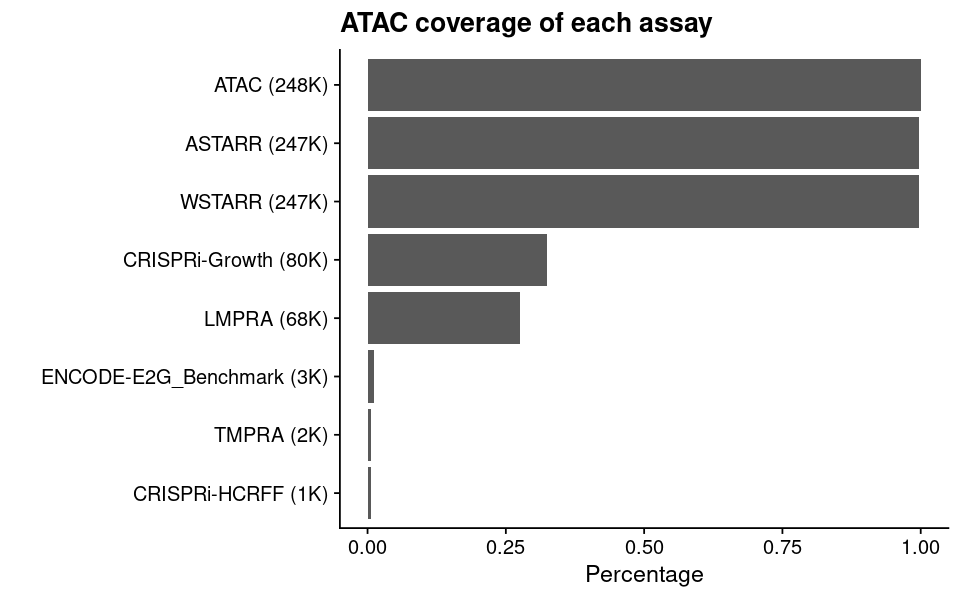

In [11]:
dat = dat_peak_atac_coverage
dat = dat %>% 
    dplyr::filter(Assay != "ENCODE-E2G_Prediction") %>%
    dplyr::arrange(Freq) %>% 
    dplyr::mutate(Assay_Label = factor(Assay_Label, levels=Assay_Label))

gpt = ggplot(dat, aes(x = Freq, y = Assay_Label)) +
    geom_col() +
    labs(x = "Percentage", y = "", title = "ATAC coverage of each assay") +
    theme_cowplot()

options(repr.plot.height=5, repr.plot.width=8)
print(gpt)
ggsave("fig.fcc_assay.atac.coverage.png", gpt, width = 6.5, height = 4.5)
ggsave("fig.fcc_assay.atac.coverage.pdf", gpt, width = 6.5, height = 4.5)

In [ ]:
dat = dat_peak_atac_fcc